#### student name: Majid Adibian
#### student number: 400131078
#### HW8 - Neural Network: BERT

#### Import Librarie 

In [2]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
from transformers import BertModel
import torch.nn.functional as F
from transformers import AdamW

import random
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import re
import os
import numpy as np

#### Read and preprocess data

In [3]:
def normalize_text(text):
    text = text.lower() # lower-case text
    text = re.sub(r"http\S+", "", text) # remove urls
    text = re.sub(r"www.\S+", "", text) # remove urls
    text = re.sub('<.*?>', '', text) # remove HTML tags
    return text

def read_data(path, train=True):
    data = []
    labels = []
    for dir_name in ['pos', 'neg']:
        dir_path = os.path.join(path, dir_name)
        for file_path in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_path)
            with open(file_path, 'r') as f:
                line = f.readline()
                line = normalize_text(line)
                data.append(line)
                labels.append(dir_name=='pos')
    data_zip = list(zip(data, labels))
    np.random.shuffle(data_zip)
    data, labels = zip(*data_zip)
    if train:
        split = 0.8
        train_data, train_labels = data[:int(len(data)*split)], labels[:int(len(data)*split)]
        val_data, val_labels = data[int(len(data)*split):], labels[int(len(data)*split):]
        
        unsup_data = []
        dir_path = os.path.join(path, 'unsup')
        for file_path in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_path)
            with open(file_path, 'r') as f:
                line = f.readline()
                line = normalize_text(line)
                unsup_data.append(line)

        return train_data, train_labels, val_data, val_labels, unsup_data
    return data, labels

In [4]:
train_data, train_labels, val_data, val_labels, unsup_data = read_data('aclImdb/train/')
test_data, test_labels= read_data('aclImdb/test/', False)
print('number of train data: ' + str(len(train_data)))
print('number of val data: ' + str(len(val_data)))
print('number of test data: ' + str(len(test_data)))

number of train data: 20000
number of val data: 5000
number of test data: 25000


#### Tokenize texts using Bert tokenizer

In [5]:
def tokenizing_text(data, tokenizer):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded_sent = tokenizer.encode_plus(
            text=text,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=500,                 # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            truncation=True,
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Tokenizing data...')
train_inputs, train_masks = tokenizing_text(train_data, tokenizer)
val_inputs, val_masks = tokenizing_text(val_data, tokenizer)
test_inputs, test_masks = tokenizing_text(test_data, tokenizer)

Tokenizing data...


/home/adibian/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#### Create Bert classification model

In [8]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(768, 64)
        self.linear2 = nn.Linear(64, 1)
        
    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = bert_out[0][:, 0, :]
        logits = self.linear2(F.relu(self.linear1(last_hidden_state_cls)))
        return torch.sigmoid(logits)

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'using {device}')
model = BertClassifier()
model = model.to(device)

using cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### Train BERT model

In [10]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, device):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []     
    val_loss, val_acc = 0, 0
    for epoch in range(num_epochs):
        train_bar = tqdm(train_dataloader)
        train_predicted = []
        train_labels = []
        train_acc_list = []
        train_losses = []
        for iter, data in enumerate(train_bar):
            model.train()
            input_ids, attn_mask, labels = tuple(t.to(device) for t in data)
            labels = labels.to(torch.float32)
            model.zero_grad()
            outputs = model(input_ids, attn_mask)
            loss_function
            outputs = outputs.flatten()
            predicted = torch.round(outputs)
            train_predicted.extend(predicted.to(int).tolist())
            train_labels.extend(labels.tolist())
            train_acc_list.extend((predicted==labels).to(int).tolist())
            optimizer.zero_grad()
            train_loss = loss_function(outputs, labels)
            train_losses.append(train_loss.item())
            train_loss.backward()
            optimizer.step()
            train_acc = sum(train_acc_list)/len(train_acc_list)
            train_loss = sum(train_losses)/len(train_losses)
            if iter%100 == 99:
                val_labels = []
                val_predicted = []
                val_acc_list = []
                val_losses = []
                model.eval()
                for val_iter, data in enumerate(val_dataloader):
                    input_ids, attn_mask, labels = tuple(t.to(device) for t in data)
                    labels = labels.to(torch.float32)
                    outputs = model(input_ids, attn_mask)
                    outputs = outputs.flatten()
                    predicted = torch.round(outputs)
                    val_predicted.extend(predicted.to(int).tolist())
                    val_labels.extend(labels.tolist())
                    val_acc_list.extend((predicted==labels).to(int).tolist())
                    val_loss = loss_function(outputs, labels)
                    val_losses.append(val_loss.item())
                val_acc = sum(val_acc_list)/len(val_acc_list)
                val_loss = sum(val_losses)/len(val_losses)

                all_train_loss.append(train_loss)
                all_train_acc.append(train_acc)
                all_val_loss.append(val_loss)
                all_val_acc.append(val_acc)
                val_confusion_mat = metrics.confusion_matrix(val_labels, val_predicted)

            train_bar.set_postfix({'train loss': train_loss, 'train acc': train_acc, 'val loss': val_loss, 'val acc': val_acc})
            train_bar.set_description('epoch {}'.format(epoch))
            train_confusion_mat = metrics.confusion_matrix(train_labels, train_predicted)
    return model, all_train_loss, all_train_acc, all_val_loss, all_val_acc, train_confusion_mat, val_confusion_mat

def test_model(model, test_dataloader, device):
    model.eval()
    loss_function = nn.BCELoss()
    test_predicted = []
    test_labels = []
    test_losses = []
    test_acc_list = []
    test_bar = tqdm(test_dataloader)
    for iter, data in enumerate(test_bar):
        input_ids, attn_mask, labels = tuple(t.to(device) for t in data)
        labels = labels.to(torch.float32)
        outputs = model(input_ids, attn_mask)
        outputs = outputs.flatten()
        predicted = torch.round(outputs)
        test_predicted.extend(predicted.to(int).tolist())
        test_labels.extend(labels.tolist())
        test_acc_list.extend((predicted==labels).to(int).tolist())
        test_loss = loss_function(outputs, labels)
        test_losses.append(test_loss.item())
    test_loss = sum(test_losses)/len(test_losses)
    test_acc = sum(test_acc_list)/len(test_acc_list)
    confusion_mat = metrics.confusion_matrix(test_labels, test_predicted)
    return test_loss, test_acc, confusion_mat

def plot_test_info(test_loss, test_acc, confusion_mat):
    print('test loss: ' + str(test_loss))
    print('test accuracy: ' + str(test_acc))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in test data')
    plt.show()
    
def plot_train_info(train_loss, train_acc, val_loss, val_acc, train_confusion_mat, val_confusion_mat):
    figure, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].plot(np.arange(0,len(train_loss)*100, 100), train_loss, label='train loss')
    axis[0].plot(np.arange(0,len(val_loss)*100, 100), val_loss, label='val loss')
    axis[0].set_title("train and validation loss")
    axis[0].set_xlabel("iterations")
    axis[0].set_ylabel("loss")
    handles, labels = axis[0].get_legend_handles_labels()
    axis[0].legend(handles, labels)

    axis[1].plot(np.arange(0,len(train_acc)*100, 100), train_acc, label='train accuracy')
    axis[1].plot(np.arange(0,len(val_acc)*100, 100), val_acc, label='val accuracy')
    axis[1].set_title("train and validation accuracy")
    axis[1].set_xlabel("iterations")
    axis[1].set_ylabel("accuracy")
    handles, labels = axis[1].get_legend_handles_labels()
    axis[1].legend(handles, labels)

    plt.tight_layout()
    plt.show()

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in train data')
    plt.show()
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_confusion_mat, display_labels=[False, True])
    cm_display.plot()
    cm_display.ax_.set_title('confusion matrix in validation data')
    plt.show()

epoch 2: 100%|██████████| 1250/1250 [14:29<00:00,  1.44it/s, train loss=0.0804, train acc=0.973, val loss=0.235, val acc=0.924]


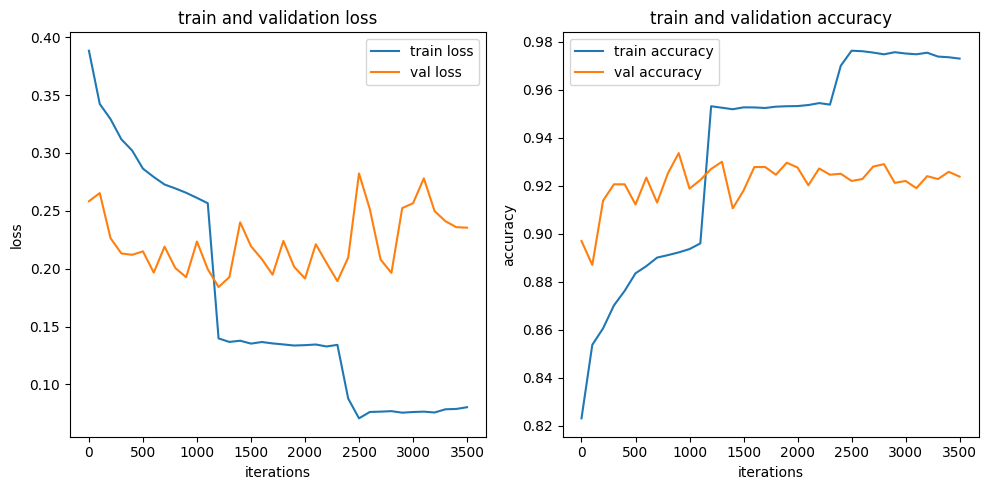

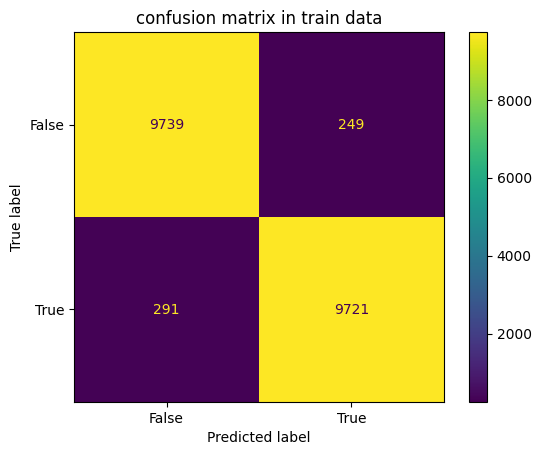

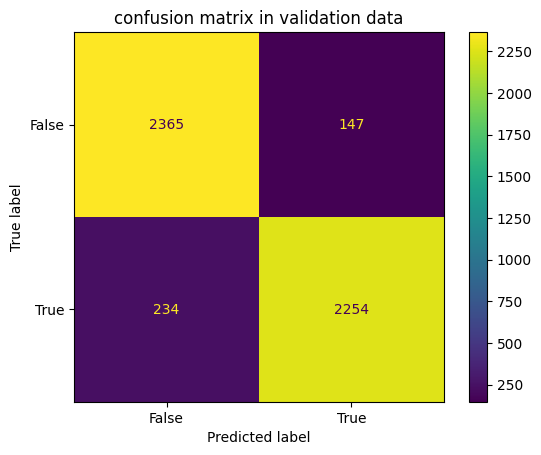

In [11]:
model, train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat = train_model(model, train_dataloader, val_dataloader, 3, device)
torch.save(model.state_dict(), 'model/bert.pt')
plot_train_info(train_loss, train_acc, val_loss, val_acc, train_conf_mat, val_conf_mat)

#### Test trained model

100%|██████████| 1563/1563 [02:52<00:00,  9.05it/s]


test loss: 0.2881703632150825
test accuracy: 0.9178


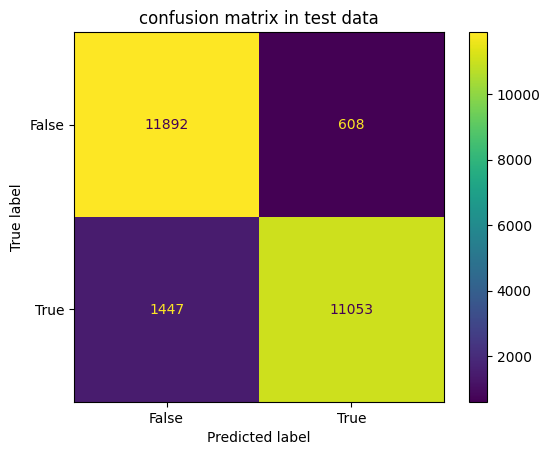

In [12]:
model.load_state_dict(torch.load('model/bert.pt', map_location=torch.device(device)))
model = model.to(device)
test_loss, test_acc, confusion_mat = test_model(model, test_dataloader, device)
plot_test_info(test_loss, test_acc, confusion_mat)

### Using transformer in different tasks

#### question-answering task (BERT, persian)

In [13]:
from transformers import pipeline

model_name = "SajjadAyoubi/bert-base-fa-qa"
qa_pipeline = pipeline("question-answering", model=model_name, tokenizer=model_name)

text = '''والیبال یک ورزش گروهی و ششمین ورزش پر طرفدار و گسترده‌ترین ورزش در بعضی کشورهای جهان است که در آن بازیکنان در دو تیم شش نفره، در دو سوی توری قرار می‌گیرند و تلاش می‌کنند تا طبق قوانین بازی، توپ را از روی تور در زمین تیم مقابل فرود آورند.
         طول زمین والیبال ۱۸ متر و عرض آن ۹ است. هرتیم حداقل باید ۳ ست (یا دست) از ۵ پنج ست بازی را ببرد، تا بتواند پیروز مسابقه شود.'''
questions = ["هرتیم والیبال چگونه می‌تواند پیروز مسابقه شود؟"]

for question in questions:
    print(qa_pipeline({"context": text, "question": question}))



{'score': 0.7102705836296082, 'start': 296, 'end': 345, 'answer': 'حداقل باید ۳ ست (یا دست) از ۵ پنج ست بازی را ببرد'}


#### Summarization task (T5)

In [14]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")

def summarize(text, max_length=150):
  input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)

  generated_ids = model.generate(input_ids=input_ids, num_beams=2, max_length=max_length,  repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)

  preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

  return preds[0]

Downloading: 100%|██████████| 25.0/25.0 [00:00<00:00, 8.95kB/s]
Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 632kB/s]
Downloading: 100%|██████████| 773k/773k [01:01<00:00, 12.9kB/s] 
Downloading: 100%|██████████| 1.74k/1.74k [00:00<00:00, 1.03MB/s]
/home/adibian/.local/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:803: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Downloading: 100%|██████████| 850M/850M [12:24<00:00, 1.20MB/s]   


In [16]:
text = '''After the sound and the fury, weeks of demonstrations and anguished calls for racial justice, the man whose death gave rise
        to an international movement, and whose last words — “I can’t breathe” — have been a rallying cry, will be laid to rest on 
        Tuesday at a private funeral in Houston.George Floyd, who was 46, will then be buried in a grave next to his mother’s.The service, 
        scheduled to begin at 11 a.m. at the Fountain of Praise church, comes after five days of public memorials in Minneapolis, North 
        Carolina and Houston and two weeks after a Minneapolis police officer was caught on video pressing his knee into Mr. Floyd’s neck 
        for nearly nine minutes before Mr. Floyd died. That officer, Derek Chauvin, has been charged with second-degree murder and 
        second-degree manslaughter. His bail was set at $1.25 million in a court appearance on Monday.'''
summary = summarize(text)
print("summary: " + summary)

summary: on Tuesday at a private funeral in Houston. Floyd, who was 46, will be buried next to his mother’s grave. A Minnesota police officer was caught on video pressing his knee into Mr. Floyd’s neck for nearly nine minutes before his death. The officer has been charged with second-degree manslaughter and his bail was set at $1.25 million. Floyd's last words — “I can’t breathe” — were a rallying cry. He was accused of killing himself.


#### Text generation task (GPT, persian)

In [13]:
from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('bolbolzaban/gpt2-persian')
generator = pipeline('text-generation', model, tokenizer=tokenizer, config={'max_length':256})
sample = generator('در یک اتفاق شگفت انگیز، پژوهشگران')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Downloading: 100%|██████████| 1.22G/1.22G [09:53<00:00, 2.22MB/s]
Setting `pad_token_id` to `eos_token_id`:9 for open-end generation.
